In [1]:
import itertools
import multiprocessing

from collections import defaultdict
from functools import partial
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pygenstability as pgs

In [4]:
N = 238
min_sale = -7
max_scale = 2
n_scale = 100
scales = np.logspace(min_sale, max_scale, n_scale)

run_params = {
    "min_scale": min_sale,
    "max_scale": max_scale,
    "n_scale": n_scale,
    "log_scale": True,
}

In [ ]:
fs_results_f = []

for s in scales:
    # file names are based on this computation
    tau = 1 / s
    s = 1 / tau
    fs_results_f.append(np.load(f"Results/Forward_partitions/forward_partitions-s={s}.npy", allow_pickle=True))

In [8]:
N_SAMPLES_WITHIN = 100
N_WORKERS = 5

In [ ]:
# Copy private functions from PyGenStability to compute NVI
# https://github.com/barahona-research-group/PyGenStability/blob/master/src/pygenstability/pygenstability.py

def _get_chunksize(n_comp, pool):
    """Split jobs accross workers for speedup."""
    return max(1, int(n_comp / pool._processes))  # pylint: disable=protected-access

def _compute_NVI(communities, all_results, pool, n_partitions=10):
    """Compute NVI measure between the first n_partitions."""
    selected_partitions = communities[:n_partitions]
    # prepare worker to compute NVI between selected partitions
    worker = partial(pgs.evaluate_NVI, partitions=selected_partitions)
    # we compute pairwise NVI only for i != j because NVI is a metric
    index_pairs = list(itertools.combinations(range(n_partitions), 2))
    chunksize = _get_chunksize(len(index_pairs), pool)
    # compute using pool of workers
    nvi_off_diagonal = list(pool.imap(worker, index_pairs, chunksize=chunksize))
    # we compute the mean NVI, using the fact that NVI is a metric
    nvi_mean = 2 * np.sum(nvi_off_diagonal) / n_partitions**2
    # append mean NVI to results
    all_results["NVI"].append(nvi_mean)

def _compute_ttprime(all_results, pool):
    """Compute NVI(t,t') from the Markov stability results."""
    # prepare worker to compute NVI between selected partitions
    worker = partial(pgs.evaluate_NVI, partitions=all_results["community_id"])
    # we compute NVI only for t < t' because NVI is a metric
    index_pairs = list(itertools.combinations(range(len(all_results["scales"])), 2))
    chunksize = _get_chunksize(len(index_pairs), pool)
    # compute NVI(t,t') for t < t'
    ttprime_list = pool.map(worker, index_pairs, chunksize=chunksize)
    # store NVI(t,'t) as symmetric matrix with zero diagonal
    all_results["ttprime"] = np.zeros([len(all_results["scales"]), len(all_results["scales"])])
    for i, ttp in enumerate(ttprime_list):
        all_results["ttprime"][index_pairs[i][0], index_pairs[i][1]] = ttp
    all_results["ttprime"] += all_results["ttprime"].T

In [10]:
all_results_f =  defaultdict(list)
all_results_f["scales"] = scales.tolist()
all_results_f["run_params"] = run_params

partitions_f = []
stabilities_f = []
nvi_within_f = []

with multiprocessing.Pool(N_WORKERS) as pool:

    for i in tqdm(range(len(scales))):

        # Extract partitions and stabilities
        partitions_set_f_i = fs_results_f[i].item().get('clusters')
        stabilities_f_i = np.array(fs_results_f[i].item().get('stabilities'))

        # Convert partitions to partition ID format
        partitions_id_f_i = []
        for partition in partitions_set_f_i:
            partition_id = np.zeros(N, dtype=int)
            for cluster_id, cluster in enumerate(partition):
                for node in cluster:
                    partition_id[node] = cluster_id
            partitions_id_f_i.append(partition_id)

        # Find the partition with the highest stability
        best_id = np.argmax(stabilities_f_i)
        all_results_f["community_id"].append(partitions_id_f_i[best_id])
        all_results_f["stability"].append(stabilities_f_i[best_id])
        all_results_f["number_of_communities"].append(len(np.unique(partitions_id_f_i[best_id])))

        # Compute within-scales NVI
        _compute_NVI(partitions_id_f_i, all_results_f, pool, n_partitions=N_SAMPLES_WITHIN)

    # Compute across-scales NVI
    _compute_ttprime(all_results_f, pool)

# save results
pgs.save_results(all_results_f, "Results/results_f.pkl")

100%|██████████| 100/100 [01:40<00:00,  1.01s/it]


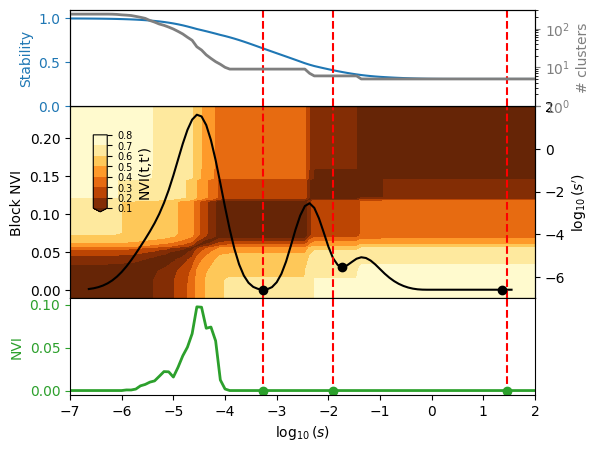

In [ ]:
# identify optimal scales
kernel_size = 10 #int(0.36 * n_scale)
window_size = 10 #int(0.05 * n_scale)
basin_radius = 2 #int(0.1 * kernel_size)

all_results_f = pgs.identify_optimal_scales(
    all_results_f,
    kernel_size=kernel_size,
    window_size=window_size,
    basin_radius=basin_radius,
    store_basins=True,
)

# save results
pgs.save_results(all_results_f, "Results/results_f.pkl")

# plot results
pgs.plot_scan_plt(all_results_f, log_scale_n_clusters=True, figure_name="Figures/scale_selection_f.svg", scale_name="s", yaxis_label_offset_left=1, yaxis_label_offset_right=1);

In [13]:
# extract robust partitions
robust_partitions_f = np.array(all_results_f["community_id"])[all_results_f["selected_partitions"]]
# save robust partitions
np.save(f"Results/robust_partitions_f.npy", robust_partitions_f)

# Sankey diagram

In [14]:
from mcf import Sankey

### Robust partitions

In [16]:
# initialise Sankey
sankey = Sankey(partitions=robust_partitions_f)
fig = sankey.plot_sankey(pad=17,thickness=2)
fig.write_image(f"Figures/robust_sankey_f.svg")

OmicsSankey - Stage 1


100%|██████████| 100/100 [00:00<00:00, 2476.30it/s]


OmicsSankey - Stage 2


100%|██████████| 100/100 [00:00<00:00, 1239.00it/s]


### Full sequence

In [17]:
# initialise Sankey
sankey = Sankey(partitions=all_results_f["community_id"])

# optimise Sankey
sankey.compute_omics_sankey(stage1_iter=200,stage2_iter=4,file_path=f"Results/sankey_f.pkl") 

OmicsSankey - Stage 1


  0%|          | 0/200 [00:00<?, ?it/s]/Users/work/miniconda3/envs/mcf/lib/python3.11/site-packages/omics_sankey/helper.py:149: RuntimeWarning:

divide by zero encountered in matmul

/Users/work/miniconda3/envs/mcf/lib/python3.11/site-packages/omics_sankey/helper.py:149: RuntimeWarning:

overflow encountered in matmul

100%|██████████| 200/200 [01:15<00:00,  2.64it/s]


OmicsSankey - Stage 2


100%|██████████| 4/4 [03:32<00:00, 53.24s/it]


In [18]:
# plot Sankey
sankey = Sankey()
sankey.load_sankey_data(f"Results/sankey_f.pkl")
fig = sankey.plot_sankey(pad=0.5,thickness=2)
fig.write_image(f"Figures/sankey_f.svg")